### Importing Libraries

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import warnings
warnings.filterwarnings('ignore')                        # To suppress all the warnings in the notebook.

### Data Load

In [39]:
df_ad_success = pd.read_csv('../../Deep Learning Foundation Projects/Advertisement Success Dataset/advertisement_success.csv')
df_ad_success.head()

,id,realtionship_status,industry,genre,targeted_sex,average_runtime(minutes_per_week),airtime,airlocation,ratings,expensive,money_back_guarantee,netgain
0,19717,Married-spouse-absent,Auto,Comedy,Male,45,Primetime,United-States,0.027465,High,No,False
1,31593,Married-civ-spouse,Pharma,Comedy,Male,45,Primetime,United-States,0.027465,Low,No,False
2,5681,Divorced,Entertainment,Comedy,Female,45,Primetime,United-States,0.027465,High,Yes,False
3,15491,Separated,Political,Infomercial,Female,40,Primetime,United-States,0.027465,Low,No,False
4,23587,Married-civ-spouse,Pharma,Comedy,Male,48,Primetime,United-States,0.027465,High,No,True


### Data Exploration

In [40]:
for col in df_ad_success.columns:
    print('Column: {0}. Unique Count: {1}'.format(col, df_ad_success[col].nunique()))

Column: id. Unique Count: 26048
Column: realtionship_status. Unique Count: 7
Column: industry. Unique Count: 6
Column: genre. Unique Count: 5
Column: targeted_sex. Unique Count: 2
Column: average_runtime(minutes_per_week). Unique Count: 91
Column: airtime. Unique Count: 3
Column: airlocation. Unique Count: 42
Column: ratings. Unique Count: 125
Column: expensive. Unique Count: 3
Column: money_back_guarantee. Unique Count: 2
Column: netgain. Unique Count: 2


In [41]:
df_ad_success.loc[df_ad_success['airlocation'] != 'United-States','airlocation'] = 'International'
df_ad_success['netgain'] = df_ad_success['netgain'].map({True:1, False:0})
df_ad_success = df_ad_success.rename(columns={'average_runtime(minutes_per_week)': 'runtime'})

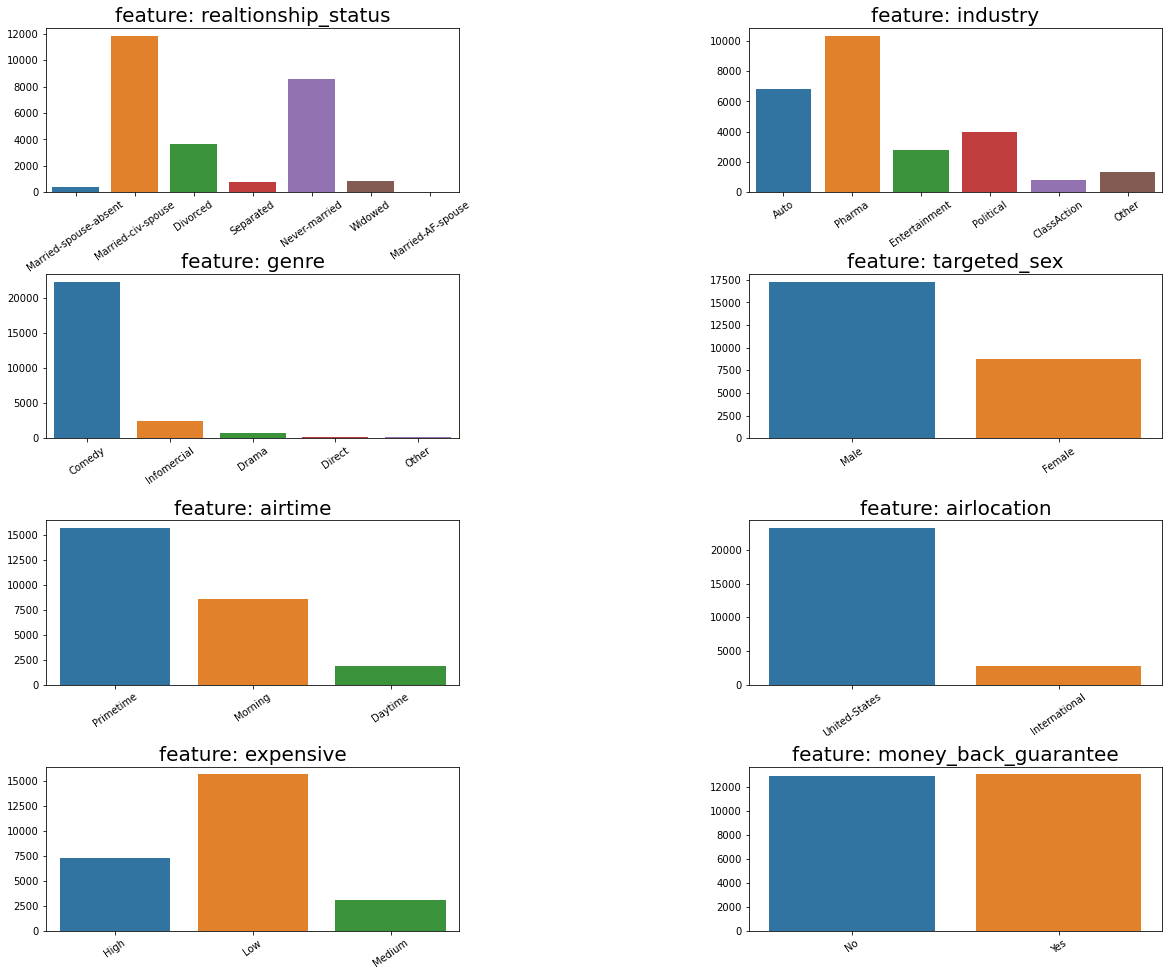

In [42]:
gs = gridspec.GridSpec(nrows=18, ncols=2)
gs.update(wspace=0.7, hspace=0.5)
plt.figure(figsize=(20,80))
for i, col in enumerate(df_ad_success.loc[:, (df_ad_success.dtypes == "object") | (df_ad_success.dtypes == "bool")]):
    ax1 = plt.subplot(gs[i])
    sns.countplot(df_ad_success[col])
    ax1.set_title('feature: ' + str(col), fontdict={'fontsize':20})
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    plt.xticks(rotation=35)
plt.show()

In [43]:
df_ad_success.describe()

,id,runtime,ratings,netgain
count,26048.000000,26048.000000,26048.000000,26048.000000
mean,16268.744779,40.294111,0.038716,0.237830
std,9413.578020,12.479457,0.075852,0.425763
min,2.000000,1.000000,0.000000,0.000000
25%,8095.750000,40.000000,0.027465,0.000000
50%,16237.000000,40.000000,0.027465,0.000000
75%,24413.500000,45.000000,0.027465,0.000000
max,32561.000000,99.000000,1.000000,1.000000


### Machine Learning

#### Common Functions

In [44]:
def call_plot_confusion_matrix(clf, X_test, y_test):
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()

In [45]:
def data_size_response(model,trX,teX,trY,teY,score_func,prob=True,n_subsets=20):
    train_errs,pseudo_test_errs = [],[]
#     subset_sizes = np.exp(np.linspace(3,np.log(trX.shape[0]),n_subsets)).astype(int)   # This is required if there are huge number of samples
    subset_sizes = np.linspace(20,trX.shape[0],n_subsets).astype(int)
    for m in tqdm((subset_sizes), position=0, leave=True,desc='Progress',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
#         print(trY[:m])
        model.fit(trX[:m],trY[:m])
        if prob:
            train_err = score_func(trY[:m],model.predict_proba(trX[:m]))
            pseudo_test_err = score_func(teY,model.predict_proba(teX))
        else:
            train_err = score_func(trY[:m],model.predict(trX[:m]))
            pseudo_test_err = score_func(teY,model.predict(teX))
#         print("training score: %.3f test score: %.3f subset size: %.3f" % (train_err,pseudo_test_err,m))
        train_errs.append(train_err)
        pseudo_test_errs.append(pseudo_test_err)

    return subset_sizes,train_errs,pseudo_test_errs

def plot_response(subset_sizes,train_errs,pseudo_test_errs):

    plt.plot(subset_sizes,train_errs,lw=2)
    plt.plot(subset_sizes,pseudo_test_errs,lw=2)
    plt.legend(['Training Score','Pseudo Test Score'])
#     plt.xscale('log')  # This is required if there are huge number of samples
    plt.ylim(0,1.02)
    plt.xlabel('Dataset size')
    plt.ylabel(str(score_func))
    plt.title('Model response to dataset size')
    plt.show()

#### Importing Libraries

In [46]:
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
import scikitplot as skplt
import matplotlib.pyplot as plt

#### Encoding Categorical Data

In [47]:
df_ad_success_with_dummies = pd.get_dummies(df_ad_success,columns=df_ad_success.select_dtypes(include=['object']).columns,
                                            drop_first=True)
df_ad_success_with_dummies.head()

,id,runtime,ratings,netgain,realtionship_status_Married-AF-spouse,realtionship_status_Married-civ-spouse,realtionship_status_Married-spouse-absent,realtionship_status_Never-married,realtionship_status_Separated,realtionship_status_Widowed,...,genre_Drama,genre_Infomercial,genre_Other,targeted_sex_Male,airtime_Morning,airtime_Primetime,airlocation_United-States,expensive_Low,expensive_Medium,money_back_guarantee_Yes
0,19717,45,0.027465,0,0,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0
1,31593,45,0.027465,0,0,1,0,0,0,0,...,0,0,0,1,0,1,1,1,0,0
2,5681,45,0.027465,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
3,15491,40,0.027465,0,0,0,0,0,1,0,...,0,1,0,0,0,1,1,1,0,0
4,23587,48,0.027465,1,0,1,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0


#### Train Test Validation Split

In [48]:
label = 'netgain'

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_ad_success_with_dummies.drop(label,axis=1).values,
                                                    df_ad_success_with_dummies[label].values,
                                                    stratify = df_ad_success_with_dummies[label].values,
                                                    test_size=0.3, shuffle=True, random_state=3)

In [50]:
print("X train Shape: ", X_train.shape)
print("X test Shape: ", X_test.shape)
print("y train Shape: ", y_train.shape)
print("y test Shape: ", y_test.shape)

X train Shape:  (18233, 25)
X test Shape:  (7815, 25)
y train Shape:  (18233,)
y test Shape:  (7815,)


In [51]:
X_pseudo_test, X_test, y_pseudo_test, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=3, 
                                                                stratify = y_test, 
                                                                shuffle=True)

In [52]:
print("X pseudo_test Shape: ", X_pseudo_test.shape)
print("X test Shape: ", X_test.shape)
print("y pseudo_test Shape: ", y_pseudo_test.shape)
print("y test Shape: ", y_test.shape)

X pseudo_test Shape:  (3907, 25)
X test Shape:  (3908, 25)
y pseudo_test Shape:  (3907,)
y test Shape:  (3908,)


#### Handling Outliers

In [53]:
model_outliers_isolation_forest = IsolationForest(random_state=3, contamination='auto')
model_outliers_isolation_forest.fit(X_train, y_train)
outlier_preds_train = model_outliers_isolation_forest.predict(X_train)
mask = outlier_preds_train != -1
X_train_wo_outliers = X_train[mask, :]
y_train_wo_outliers = y_train[mask]
print("Before Handling Outliers: ",pd.DataFrame(X_train).shape,",", len(y_train))
print("After Handling Outliers: ",pd.DataFrame(X_train_wo_outliers).shape, ",", len(y_train_wo_outliers))

Before Handling Outliers:  (18233, 25) , 18233
After Handling Outliers:  (14491, 25) , 14491


In [54]:
outlier_preds_pseudo_test = model_outliers_isolation_forest.predict(X_pseudo_test)
mask = outlier_preds_pseudo_test != -1
X_pseudo_test_wo_outliers = X_pseudo_test[mask, :]
y_pseudo_test_wo_outliers = y_pseudo_test[mask]
print("Before Handling Outliers: ",pd.DataFrame(X_pseudo_test).shape,",", len(y_pseudo_test))
print("After Handling Outliers: ",pd.DataFrame(X_pseudo_test_wo_outliers).shape, ",", len(y_pseudo_test_wo_outliers))

Before Handling Outliers:  (3907, 25) , 3907
After Handling Outliers:  (3102, 25) , 3102


In [55]:
outlier_preds_test = model_outliers_isolation_forest.predict(X_test)
mask = outlier_preds_test != -1
X_test_wo_outliers = X_test[mask, :]
y_test_wo_outliers = y_test[mask]
print("Before Handling Outliers: ",pd.DataFrame(X_test).shape,",", len(y_test))
print("After Handling Outliers: ",pd.DataFrame(X_test_wo_outliers).shape, ",", len(y_test_wo_outliers))

Before Handling Outliers:  (3908, 25) , 3908
After Handling Outliers:  (3070, 25) , 3070


#### Data Scaling

In [56]:
model_scaler = StandardScaler()
X_train_wo_outliers_scaled = model_scaler.fit_transform(X_train_wo_outliers)
X_pseudo_test_wo_outliers_scaled = model_scaler.transform(X_pseudo_test_wo_outliers)
X_test_wo_outliers_scaled = model_scaler.transform(X_test_wo_outliers)

#### Feature Selection

##### std == 0

In [57]:
drop_cols=[]
for cols in pd.DataFrame(X_train_wo_outliers_scaled).columns:
    if pd.DataFrame(X_train_wo_outliers_scaled)[cols].std()==0:
        drop_cols.append(cols)
print("Number of features with zero variance that are to be dropped: ", len(drop_cols),'\n')
print(drop_cols)
pd.DataFrame(X_train_wo_outliers_scaled).drop(drop_cols,axis=1, inplace = True)

Number of features with zero variance that are to be dropped:  0 

[]


##### PCA

In [58]:
model_pca = PCA(0.99).fit(X_train_wo_outliers_scaled)

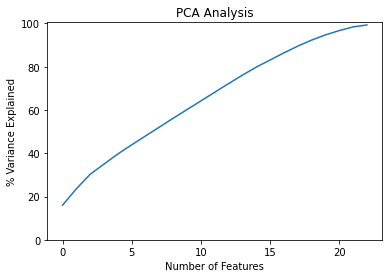

In [59]:
var=np.cumsum(np.round(model_pca.explained_variance_ratio_, decimals=3)*100)
plt.ylabel('% Variance Explained')
plt.xlabel('Number of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

In [60]:
print('%d components explain 99%% of the variation in data' % model_pca.n_components_)

23 components explain 99% of the variation in data


In [61]:
model_pca_post_knee_plot = PCA(n_components=model_pca.n_components_, random_state = 0)
model_pca_post_knee_plot.fit(X_train_wo_outliers_scaled)
X_train_wo_outliers_scaled_post_PCA = model_pca_post_knee_plot.transform(X_train_wo_outliers_scaled)
print(X_train_wo_outliers_scaled_post_PCA.shape)

(14491, 23)


In [62]:
X_pseudo_test_wo_outliers_scaled_post_PCA = model_pca_post_knee_plot.transform(X_pseudo_test_wo_outliers_scaled)
print(X_pseudo_test_wo_outliers_scaled_post_PCA.shape)

(3102, 23)


In [63]:
X_test_wo_outliers_scaled_post_PCA = model_pca_post_knee_plot.transform(X_test_wo_outliers_scaled)
print(X_test_wo_outliers_scaled_post_PCA.shape)

(3070, 23)


#### Model Building

##### Logistic Regression

In [64]:
model_logreg = LogisticRegression(random_state=3)
model_logreg.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_logreg = model_logreg.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_pseudo_test_logreg = model_logreg.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
y_pred_test_logreg = model_logreg.predict(X_test_wo_outliers_scaled_post_PCA)

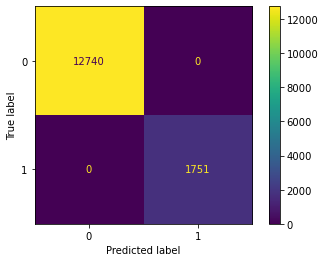

In [65]:
call_plot_confusion_matrix(model_logreg, X_train_wo_outliers_scaled_post_PCA, y_pred_train_logreg)

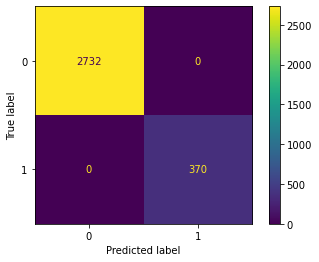

In [66]:
call_plot_confusion_matrix(model_logreg, X_pseudo_test_wo_outliers_scaled_post_PCA, y_pred_pseudo_test_logreg)

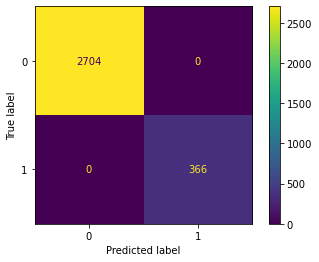

In [67]:
call_plot_confusion_matrix(model_logreg, X_test_wo_outliers_scaled_post_PCA, y_pred_test_logreg)

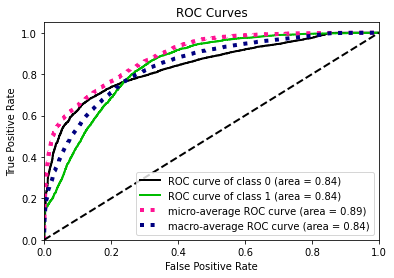

In [68]:
skplt.metrics.plot_roc_curve(y_train_wo_outliers, model_logreg.predict_proba(X_train_wo_outliers_scaled_post_PCA))
plt.show()

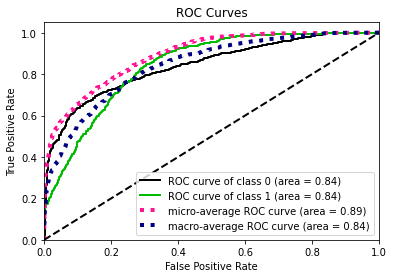

In [69]:
skplt.metrics.plot_roc_curve(y_pseudo_test_wo_outliers, model_logreg.predict_proba(X_pseudo_test_wo_outliers_scaled_post_PCA))
plt.show()

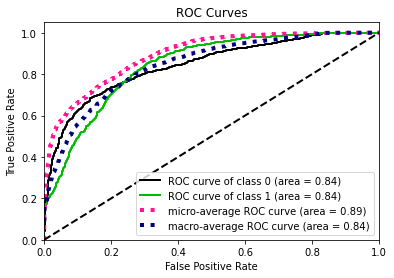

In [70]:
skplt.metrics.plot_roc_curve(y_test_wo_outliers, model_logreg.predict_proba(X_test_wo_outliers_scaled_post_PCA))
plt.show()

##### Logistic Regression - Random Search Tuned

In [71]:
param_dist = {
    "solver": ['newton-cg', 'lbfgs', 'liblinear'],
    "penalty": ['l1','l2'],
    "C": [100, 10, 1.0, 0.1, 0.01]
}
model_logreg_random_tune = RandomizedSearchCV(LogisticRegression(random_state=3),param_distributions=param_dist, n_iter=100)
model_logreg_random_tune.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_logreg_random_tune = model_logreg_random_tune.best_estimator_.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_pseudo_test_logreg_random_tune = model_logreg_random_tune.best_estimator_.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
y_pred_test_logreg_random_tune = model_logreg_random_tune.best_estimator_.predict(X_test_wo_outliers_scaled_post_PCA)

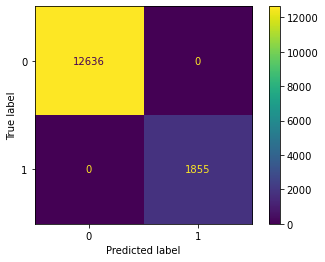

In [72]:
call_plot_confusion_matrix(model_logreg_random_tune, X_train_wo_outliers_scaled_post_PCA, y_pred_train_logreg_random_tune)

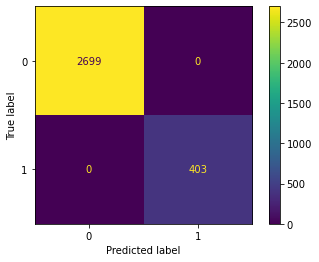

In [73]:
call_plot_confusion_matrix(model_logreg_random_tune, X_pseudo_test_wo_outliers_scaled_post_PCA, y_pred_pseudo_test_logreg_random_tune)

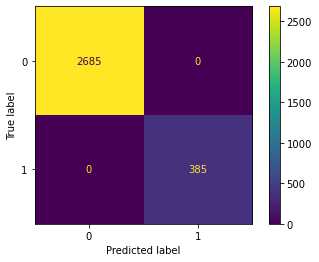

In [74]:
call_plot_confusion_matrix(model_logreg_random_tune, X_test_wo_outliers_scaled_post_PCA, y_pred_test_logreg_random_tune)

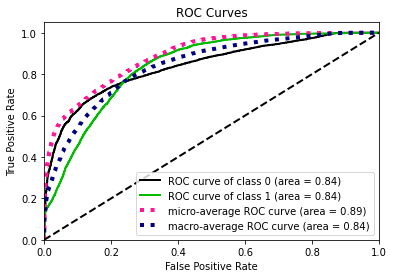

In [75]:
skplt.metrics.plot_roc_curve(y_train_wo_outliers, model_logreg_random_tune.predict_proba(X_train_wo_outliers_scaled_post_PCA))
plt.show()

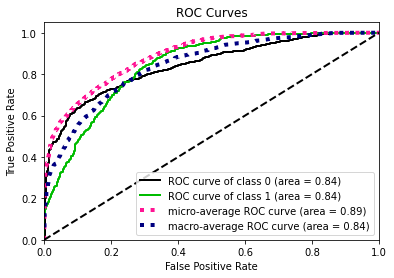

In [76]:
skplt.metrics.plot_roc_curve(y_pseudo_test_wo_outliers, model_logreg_random_tune.predict_proba(X_pseudo_test_wo_outliers_scaled_post_PCA))
plt.show()

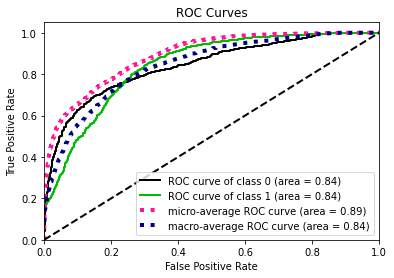

In [77]:
skplt.metrics.plot_roc_curve(y_test_wo_outliers, model_logreg_random_tune.predict_proba(X_test_wo_outliers_scaled_post_PCA))
plt.show()

##### Decision Tree

In [78]:
model_dectree = tree.DecisionTreeClassifier(random_state=3)
model_dectree.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_dectree = model_dectree.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_pseudo_test_dectree = model_dectree.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
y_pred_test_dectree = model_dectree.predict(X_test_wo_outliers_scaled_post_PCA)

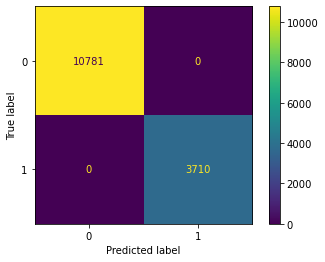

In [79]:
call_plot_confusion_matrix(model_dectree, X_train_wo_outliers_scaled_post_PCA, y_pred_train_dectree)

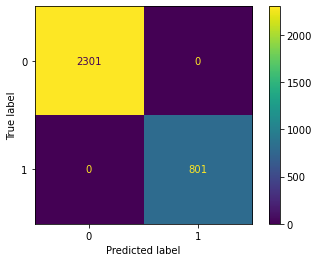

In [80]:
call_plot_confusion_matrix(model_dectree, X_pseudo_test_wo_outliers_scaled_post_PCA, y_pred_pseudo_test_dectree)

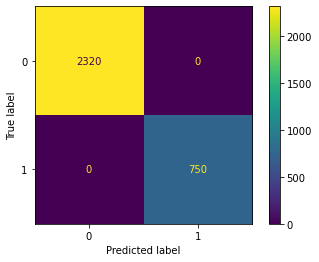

In [81]:
call_plot_confusion_matrix(model_dectree, X_test_wo_outliers_scaled_post_PCA, y_pred_test_dectree)

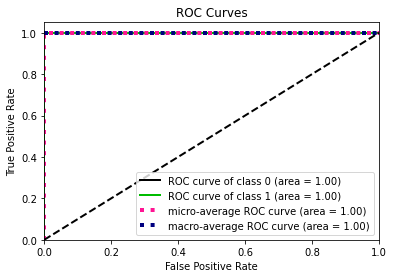

In [82]:
skplt.metrics.plot_roc_curve(y_train_wo_outliers, model_dectree.predict_proba(X_train_wo_outliers_scaled_post_PCA))
plt.show()

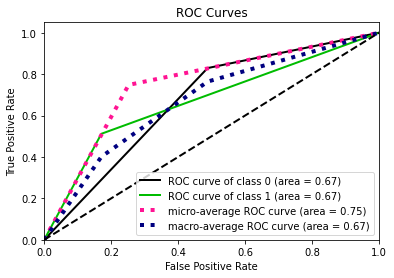

In [83]:
skplt.metrics.plot_roc_curve(y_pseudo_test_wo_outliers, model_dectree.predict_proba(X_pseudo_test_wo_outliers_scaled_post_PCA))
plt.show()

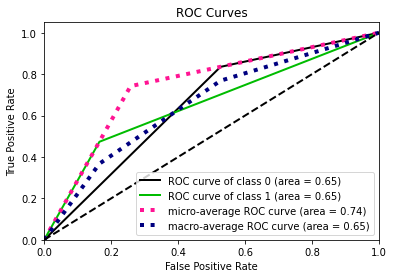

In [84]:
skplt.metrics.plot_roc_curve(y_test_wo_outliers, model_dectree.predict_proba(X_test_wo_outliers_scaled_post_PCA))
plt.show()

##### Random Forest

In [85]:
model_rforest = RandomForestClassifier(random_state=3, n_estimators=800, max_depth=20)
model_rforest.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_rforest = model_rforest.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_pseudo_test_rforest = model_rforest.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
y_pred_test_rforest = model_rforest.predict(X_test_wo_outliers_scaled_post_PCA)

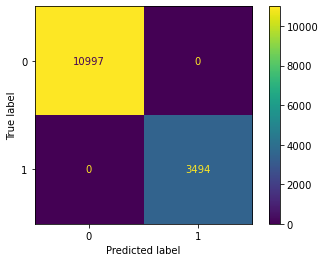

In [86]:
call_plot_confusion_matrix(model_rforest, X_train_wo_outliers_scaled_post_PCA, y_pred_train_rforest)

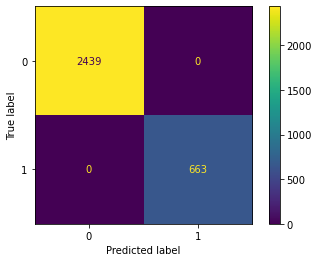

In [87]:
call_plot_confusion_matrix(model_rforest, X_pseudo_test_wo_outliers_scaled_post_PCA, y_pred_pseudo_test_rforest)

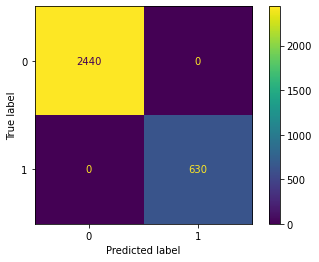

In [88]:
call_plot_confusion_matrix(model_rforest, X_test_wo_outliers_scaled_post_PCA, y_pred_test_rforest)

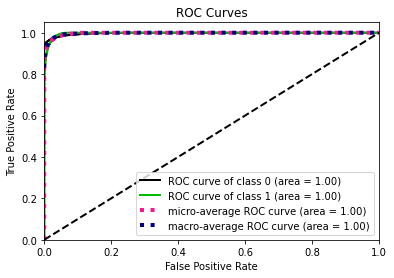

In [89]:
skplt.metrics.plot_roc_curve(y_train_wo_outliers, model_rforest.predict_proba(X_train_wo_outliers_scaled_post_PCA))
plt.show()

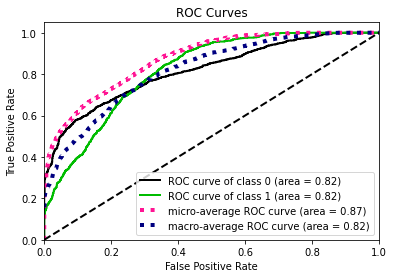

In [90]:
skplt.metrics.plot_roc_curve(y_pseudo_test_wo_outliers, model_rforest.predict_proba(X_pseudo_test_wo_outliers_scaled_post_PCA))
plt.show()

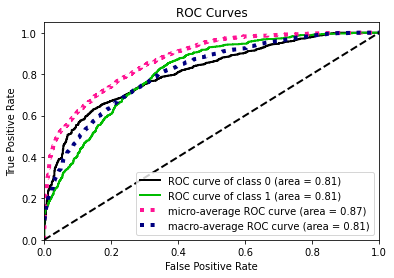

In [91]:
skplt.metrics.plot_roc_curve(y_test_wo_outliers, model_rforest.predict_proba(X_test_wo_outliers_scaled_post_PCA))
plt.show()

##### Random Forest - Random Search Tuned

In [94]:
param_dist = {"max_depth": range(25,30),
#               "min_samples_split": range(6,11),
#               "min_samples_leaf": range(1,5),
              "n_estimators": [400, 800],
#               "criterion" : ["gini", "entropy"],
#               'max_features': ['sqrt', 'log2', None]
             }
model_rforest_random_tune = RandomizedSearchCV(RandomForestClassifier(random_state=3),param_distributions=param_dist,n_iter=100)
model_rforest_random_tune.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_rforest_random_tune = model_rforest_random_tune.best_estimator_.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_pseudo_test_rforest_random_tune = model_rforest_random_tune.best_estimator_.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
y_pred_test_rforest_random_tune = model_rforest_random_tune.best_estimator_.predict(X_test_wo_outliers_scaled_post_PCA)

In [101]:
model_rforest_random_tune.best_estimator_

RandomForestClassifier(max_depth=25, n_estimators=400, random_state=3)

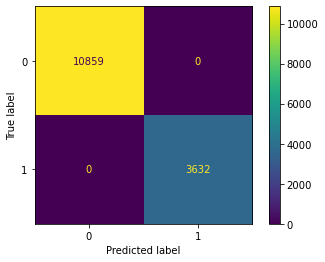

In [96]:
call_plot_confusion_matrix(model_rforest_random_tune.best_estimator_, X_train_wo_outliers_scaled_post_PCA,
                           y_pred_train_rforest_random_tune)

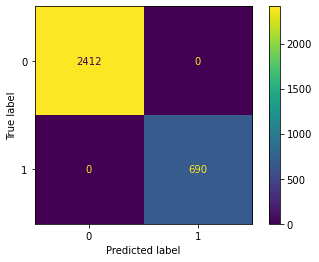

In [99]:
call_plot_confusion_matrix(model_rforest_random_tune, X_pseudo_test_wo_outliers_scaled_post_PCA, y_pred_pseudo_test_rforest_random_tune)

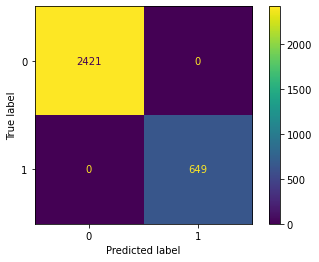

In [100]:
call_plot_confusion_matrix(model_rforest_random_tune, X_test_wo_outliers_scaled_post_PCA, y_pred_test_rforest_random_tune)

##### Gaussian Naive Bayes

In [102]:
model_gnb = GaussianNB()
model_gnb.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_gnb = model_gnb.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_pseudo_test_gnb = model_gnb.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
y_pred_test_gnb = model_gnb.predict(X_test_wo_outliers_scaled_post_PCA)

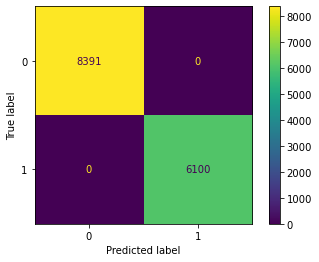

In [103]:
call_plot_confusion_matrix(model_gnb, X_train_wo_outliers_scaled_post_PCA, y_pred_train_gnb)

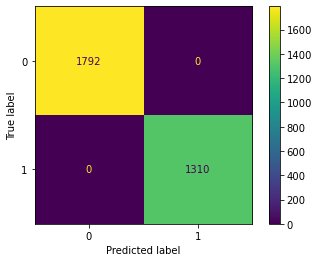

In [104]:
call_plot_confusion_matrix(model_gnb, X_pseudo_test_wo_outliers_scaled_post_PCA, y_pred_pseudo_test_gnb)

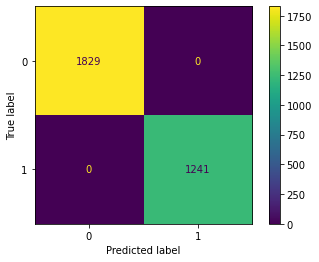

In [105]:
call_plot_confusion_matrix(model_gnb, X_test_wo_outliers_scaled_post_PCA, y_pred_test_gnb)

##### K Nearest Neighbours - Random Search Tuned

In [106]:
param_dist = {"n_neighbors": range(5,20),
              "p": range(1,5),
              "metric": ["minkowski","euclidean","chebyshev"]
             }
n_iter_search = 100
model_knn_random_tune = KNeighborsClassifier()
model_random_tune_knn = RandomizedSearchCV(model_knn_random_tune,param_distributions=param_dist,n_iter=n_iter_search)
model_random_tune_knn.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_knn_random_tune = model_random_tune_knn.best_estimator_.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_pseudo_test_knn_random_tune = model_random_tune_knn.best_estimator_.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
y_pred_test_knn_random_tune = model_random_tune_knn.best_estimator_.predict(X_test_wo_outliers_scaled_post_PCA)

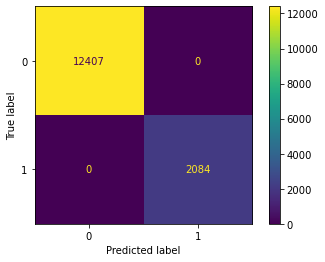

In [107]:
call_plot_confusion_matrix(model_random_tune_knn, X_train_wo_outliers_scaled_post_PCA, y_pred_train_knn_random_tune)

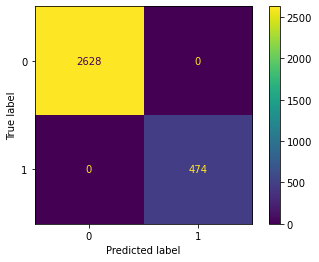

In [108]:
call_plot_confusion_matrix(model_random_tune_knn, X_pseudo_test_wo_outliers_scaled_post_PCA, y_pred_pseudo_test_knn_random_tune)

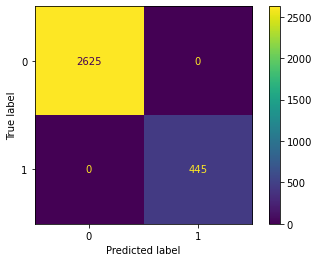

In [109]:
call_plot_confusion_matrix(model_random_tune_knn, X_test_wo_outliers_scaled_post_PCA, y_pred_test_knn_random_tune)

##### Support Vector Classifier

In [110]:
model_svc = SVC(random_state=3)
model_svc.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_svc = model_svc.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_pseudo_test_svc = model_svc.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
y_pred_test_svc = model_svc.predict(X_test_wo_outliers_scaled_post_PCA)

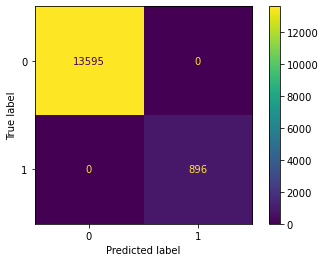

In [111]:
call_plot_confusion_matrix(model_svc, X_train_wo_outliers_scaled_post_PCA, y_pred_train_svc)

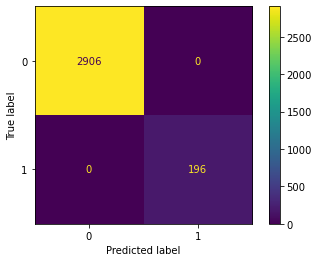

In [112]:
call_plot_confusion_matrix(model_svc, X_pseudo_test_wo_outliers_scaled_post_PCA, y_pred_pseudo_test_svc)

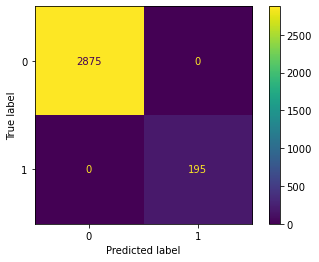

In [113]:
call_plot_confusion_matrix(model_svc, X_test_wo_outliers_scaled_post_PCA, y_pred_test_svc)

##### Support Vector Classifier - Random Search Tuned

In [114]:
# param_dist = {'kernel' : ['linear', 'rbf', 'poly'],
#               'gamma' : [0.1, 1, 10, 100],
#               'C' : [0.1, 1, 10, 100, 1000],
#               'degree' : [0, 1, 2, 3, 4, 5, 6]}
# n_iter_search = 100
# model_svc_random_tune = SVC(random_state=3)
# model_random_tune_svc = RandomizedSearchCV(model_svc_random_tune,param_distributions=param_dist,n_iter=n_iter_search)
# model_random_tune_svc.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
# y_pred_train_svc_random_tune = model_random_tune_svc.best_estimator_.predict(X_train_wo_outliers_scaled_post_PCA)
# y_pred_pseudo_test_svc_random_tune = model_random_tune_svc.best_estimator_.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
# y_pred_test_svc_random_tune = model_random_tune_svc.best_estimator_.predict(X_test_wo_outliers_scaled_post_PCA)

KeyboardInterrupt: 

In [ ]:
# call_plot_confusion_matrix(model_random_tune_svc, X_train_wo_outliers_scaled_post_PCA, y_pred_train_svc_random_tune)

In [ ]:
# call_plot_confusion_matrix(model_random_tune_svc, X_pseudo_test_wo_outliers_scaled_post_PCA, y_pred_pseudo_test_svc_random_tune)

In [ ]:
# call_plot_confusion_matrix(model_random_tune_svc, X_test_wo_outliers_scaled_post_PCA, y_pred_test_svc_random_tune)

##### Voting Classifier - KNN - Random Search Tuned, Logistic Regression and Support Vector Classifier

In [115]:
model_voting_classifier = VotingClassifier(estimators=[('knn_t', model_random_tune_knn),
                                                       ('lr',model_logreg),
                                                       ('svc', model_svc)], voting='hard')
model_voting_classifier.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_voting_classifier = model_voting_classifier.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_pseudo_test_voting_classifier = model_voting_classifier.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
y_pred_test_voting_classifier = model_voting_classifier.predict(X_test_wo_outliers_scaled_post_PCA)

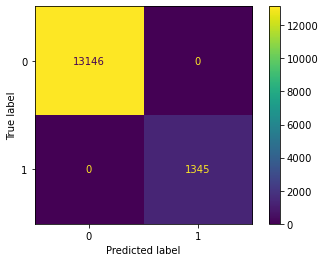

In [116]:
call_plot_confusion_matrix(model_voting_classifier, X_train_wo_outliers_scaled_post_PCA, y_pred_train_voting_classifier)

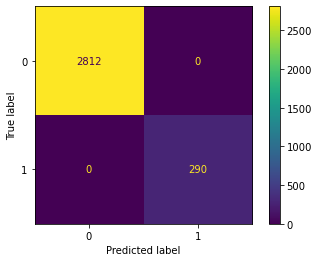

In [117]:
call_plot_confusion_matrix(model_voting_classifier, X_pseudo_test_wo_outliers_scaled_post_PCA, y_pred_pseudo_test_voting_classifier)

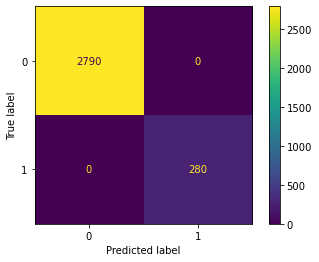

In [118]:
call_plot_confusion_matrix(model_voting_classifier, X_test_wo_outliers_scaled_post_PCA, y_pred_test_voting_classifier)

##### Bagging Classifier

In [119]:
model_bagging_classifier = BaggingClassifier(tree.DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True,
                                             )
model_bagging_classifier.fit(X_train_wo_outliers_scaled_post_PCA, y_train_wo_outliers)
y_pred_train_bagging_classifier = model_bagging_classifier.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_pseudo_test_bagging_classifier = model_bagging_classifier.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
y_pred_test_bagging_classifier = model_bagging_classifier.predict(X_test_wo_outliers_scaled_post_PCA)

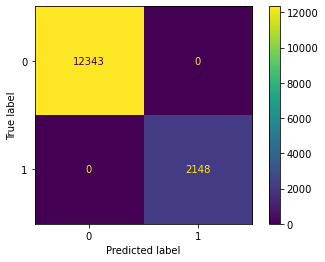

In [120]:
call_plot_confusion_matrix(model_bagging_classifier, X_train_wo_outliers_scaled_post_PCA, y_pred_train_bagging_classifier)

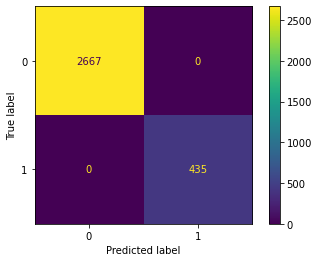

In [121]:
call_plot_confusion_matrix(model_bagging_classifier, X_pseudo_test_wo_outliers_scaled_post_PCA, y_pred_pseudo_test_bagging_classifier)

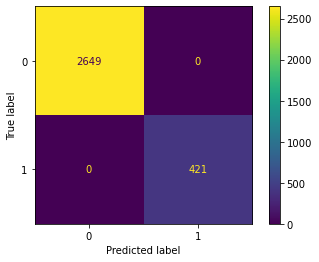

In [122]:
call_plot_confusion_matrix(model_bagging_classifier, X_test_wo_outliers_scaled_post_PCA, y_pred_test_bagging_classifier)

##### Adaboost Classifier

In [123]:
model_adaboost_classifier = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1))
model_adaboost_classifier.fit(X_train_wo_outliers_scaled_post_PCA, y_train_wo_outliers)
y_pred_train_adaboost_classifier = model_adaboost_classifier.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_pseudo_test_adaboost_classifier = model_adaboost_classifier.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
y_pred_test_adaboost_classifier = model_adaboost_classifier.predict(X_test_wo_outliers_scaled_post_PCA)

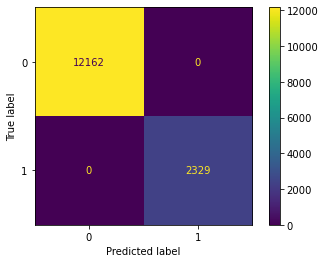

In [124]:
call_plot_confusion_matrix(model_adaboost_classifier, X_train_wo_outliers_scaled_post_PCA, y_pred_train_adaboost_classifier)

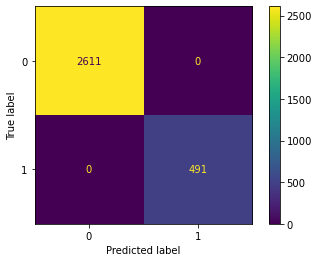

In [125]:
call_plot_confusion_matrix(model_adaboost_classifier, X_pseudo_test_wo_outliers_scaled_post_PCA, y_pred_pseudo_test_adaboost_classifier)

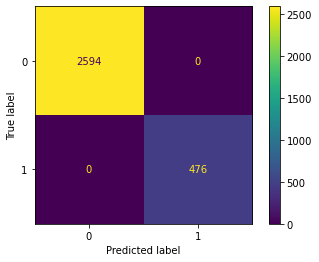

In [126]:
call_plot_confusion_matrix(model_adaboost_classifier, X_test_wo_outliers_scaled_post_PCA, y_pred_test_adaboost_classifier)

##### Gradient Boosting Classifier

In [127]:
model_gdboost_classifier = GradientBoostingClassifier(n_estimators=100, random_state=3, learning_rate = 0.10)
model_gdboost_classifier.fit(X_train_wo_outliers_scaled_post_PCA, y_train_wo_outliers)
y_pred_train_gdboost_classifier = model_gdboost_classifier.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_pseudo_test_gdboost_classifier = model_gdboost_classifier.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
y_pred_test_gdboost_classifier = model_gdboost_classifier.predict(X_test_wo_outliers_scaled_post_PCA)

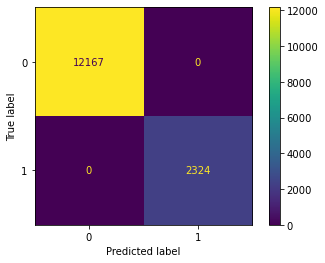

In [128]:
call_plot_confusion_matrix(model_gdboost_classifier, X_train_wo_outliers_scaled_post_PCA, y_pred_train_gdboost_classifier)

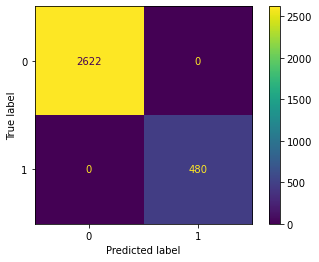

In [129]:
call_plot_confusion_matrix(model_gdboost_classifier, X_pseudo_test_wo_outliers_scaled_post_PCA, y_pred_pseudo_test_gdboost_classifier)

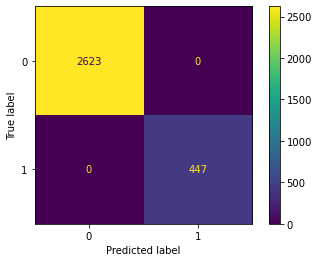

In [130]:
call_plot_confusion_matrix(model_gdboost_classifier, X_test_wo_outliers_scaled_post_PCA, y_pred_test_gdboost_classifier)

##### XGBoost Classifier

In [131]:
model_xgboost_classifier = XGBClassifier(n_estimators=100, random_state=3, learning_rate = 0.15)
model_xgboost_classifier.fit(X_train_wo_outliers_scaled_post_PCA, y_train_wo_outliers)
y_pred_train_xgboost_classifier = model_xgboost_classifier.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_pseudo_test_xgboost_classifier = model_xgboost_classifier.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
y_pred_test_xgboost_classifier = model_xgboost_classifier.predict(X_test_wo_outliers_scaled_post_PCA)

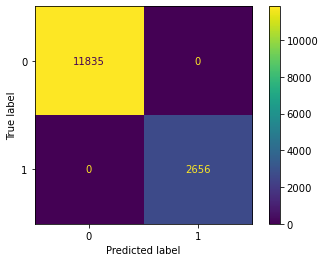

In [132]:
call_plot_confusion_matrix(model_xgboost_classifier, X_train_wo_outliers_scaled_post_PCA, y_pred_train_xgboost_classifier)

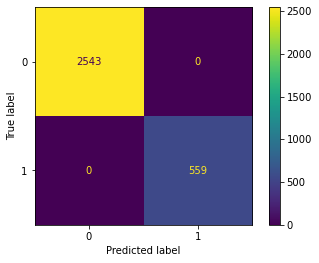

In [133]:
call_plot_confusion_matrix(model_xgboost_classifier, X_pseudo_test_wo_outliers_scaled_post_PCA, y_pred_pseudo_test_xgboost_classifier)

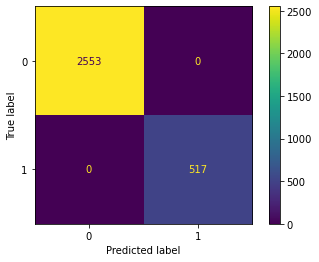

In [134]:
call_plot_confusion_matrix(model_xgboost_classifier, X_test_wo_outliers_scaled_post_PCA, y_pred_test_xgboost_classifier)

##### Voting Classifier - Logistic Regression, Gaussian Naive Bayes & Support Vector Classifier

In [135]:
model_voting_classifier_2 = VotingClassifier(estimators=[('lr',model_logreg),
                                                       ('gnb', model_gnb), ('svc', model_svc)], voting='hard')
model_voting_classifier_2.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_voting_classifier_2 = model_voting_classifier_2.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_pseudo_test_voting_classifier_2 = model_voting_classifier_2.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
y_pred_test_voting_classifier_2 = model_voting_classifier_2.predict(X_test_wo_outliers_scaled_post_PCA)

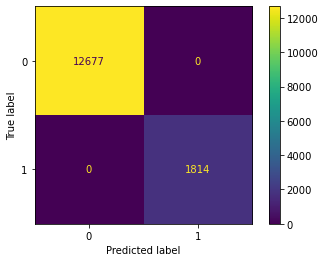

In [136]:
call_plot_confusion_matrix(model_voting_classifier_2, X_train_wo_outliers_scaled_post_PCA, y_pred_train_voting_classifier_2)

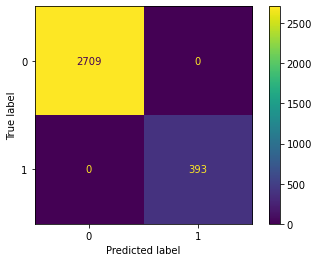

In [137]:
call_plot_confusion_matrix(model_voting_classifier_2, X_pseudo_test_wo_outliers_scaled_post_PCA, 
                           y_pred_pseudo_test_voting_classifier_2)

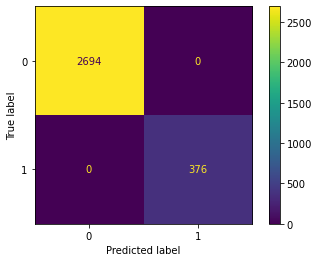

In [138]:
call_plot_confusion_matrix(model_voting_classifier_2, X_test_wo_outliers_scaled_post_PCA, y_pred_test_voting_classifier_2)

##### Voting Classifier - Random Forest, Decision Tree, KNN - Random Search Tuned & XGBoost Classifiers

In [139]:
model_voting_classifier_3 = VotingClassifier(estimators=[('rforest',model_rforest), ('dectree', model_dectree),
                                                         ('knn_t', model_random_tune_knn.best_estimator_),
                                                         ('xgb', model_xgboost_classifier)], voting='hard')
model_voting_classifier_3.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_voting_classifier_3 = model_voting_classifier_3.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_pseudo_test_voting_classifier_3 = model_voting_classifier_3.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
y_pred_test_voting_classifier_3 = model_voting_classifier_3.predict(X_test_wo_outliers_scaled_post_PCA)

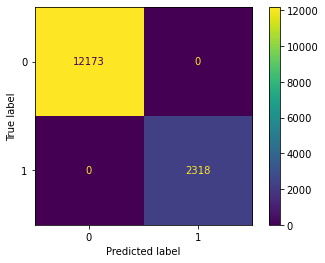

In [140]:
call_plot_confusion_matrix(model_voting_classifier_3, X_train_wo_outliers_scaled_post_PCA, y_pred_train_voting_classifier_3)

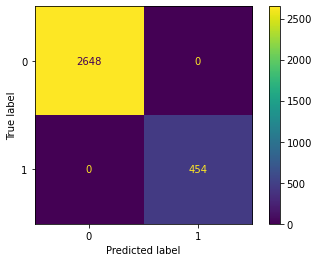

In [141]:
call_plot_confusion_matrix(model_voting_classifier_3, X_pseudo_test_wo_outliers_scaled_post_PCA, 
                           y_pred_pseudo_test_voting_classifier_3)

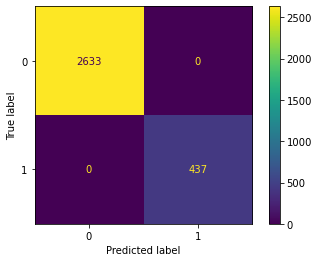

In [142]:
call_plot_confusion_matrix(model_voting_classifier_3, X_test_wo_outliers_scaled_post_PCA, y_pred_test_voting_classifier_3)

##### Stochastic Gradient Descent Classifier

In [143]:
model_sgd_classifier = SGDClassifier(random_state=3)
model_sgd_classifier.fit(X_train_wo_outliers_scaled_post_PCA,y_train_wo_outliers)
y_pred_train_sgd_classifier = model_sgd_classifier.predict(X_train_wo_outliers_scaled_post_PCA)
y_pred_pseudo_test_sgd_classifier = model_sgd_classifier.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
y_pred_test_sgd_classifier = model_sgd_classifier.predict(X_test_wo_outliers_scaled_post_PCA)

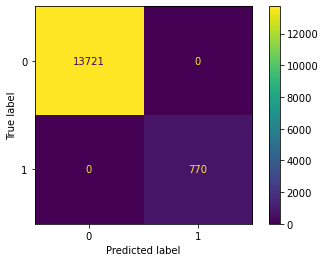

In [144]:
call_plot_confusion_matrix(model_sgd_classifier, X_train_wo_outliers_scaled_post_PCA, y_pred_train_sgd_classifier)

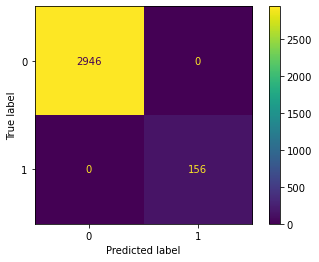

In [145]:
call_plot_confusion_matrix(model_sgd_classifier, X_pseudo_test_wo_outliers_scaled_post_PCA, y_pred_pseudo_test_sgd_classifier)

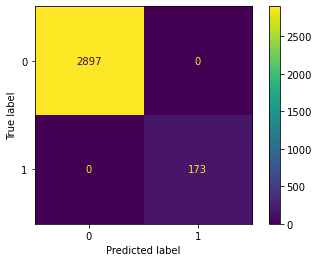

In [146]:
call_plot_confusion_matrix(model_sgd_classifier, X_test_wo_outliers_scaled_post_PCA, y_pred_test_sgd_classifier)

#### Model Evaluation

In [147]:
df_scores = pd.DataFrame()
lstClassifier = []
lstAccuracy = []
lstRecall = []
lstPrecision = []
lstF1 = []
for clf in (model_adaboost_classifier, model_bagging_classifier, model_dectree, model_gdboost_classifier, model_gnb,
            model_knn_random_tune, model_logreg, model_rforest, model_svc, model_voting_classifier, model_xgboost_classifier,
            model_voting_classifier_2, model_voting_classifier_3):
    clf.fit(X_train_wo_outliers_scaled_post_PCA, y_train_wo_outliers)
    y_pred = clf.predict(X_pseudo_test_wo_outliers_scaled_post_PCA)
    lstClassifier.append(clf.__class__.__name__)
    lstAccuracy.append(accuracy_score(y_pseudo_test_wo_outliers, y_pred))
    lstRecall.append(recall_score(y_pseudo_test_wo_outliers, y_pred))
    lstPrecision.append(precision_score(y_pseudo_test_wo_outliers, y_pred))
    lstF1.append(f1_score(y_pseudo_test_wo_outliers, y_pred))
df_scores['classifier'] = pd.Series(lstClassifier)
df_scores['accuracy'] = pd.Series(lstAccuracy)
df_scores['recall'] = pd.Series(lstRecall)
df_scores['precision'] = pd.Series(lstPrecision)
df_scores['f1'] = pd.Series(lstF1)
df_scores

,classifier,accuracy,recall,precision,f1
0,AdaBoostClassifier,0.789813,0.398742,0.645621,0.493002
1,BaggingClassifier,0.781109,0.378616,0.619342,0.469945
2,DecisionTreeClassifier,0.747905,0.511950,0.508115,0.510025
3,GradientBoostingClassifier,0.785622,0.383648,0.635417,0.478431
4,GaussianNB,0.724371,0.786164,0.477099,0.593824
5,KNeighborsClassifier,0.761767,0.447799,0.542683,0.490696
6,LogisticRegression,0.786912,0.316981,0.681081,0.432618
7,RandomForestClassifier,0.764023,0.456604,0.547511,0.497942
8,SVC,0.783043,0.200000,0.811224,0.320888
9,VotingClassifier,0.786267,0.265409,0.727586,0.388940


In [148]:
print('Best Accuracy by Model: {0} : {1}\n'.format(df_scores[df_scores['accuracy'] == df_scores['accuracy'].max()]['classifier'], 
                                                 df_scores['accuracy'].max()))
print('Best Recall by Model: {0} : {1}\n'.format(df_scores[df_scores['recall'] == df_scores['recall'].max()]['classifier'], 
                                                 df_scores['recall'].max()))
print('Best Precision by Model: {0} : {1}\n'.format(df_scores[df_scores['precision'] == df_scores['precision'].max()]['classifier'], 
                                                 df_scores['precision'].max()))
print('Best F1 by Model: {0} : {1}\n'.format(df_scores[df_scores['f1'] == df_scores['f1'].max()]['classifier'], 
                                                 df_scores['f1'].max()))

Best Accuracy by Model: 0    AdaBoostClassifier
Name: classifier, dtype: object : 0.7898130238555771

Best Recall by Model: 4    GaussianNB
Name: classifier, dtype: object : 0.7861635220125787

Best Precision by Model: 8    SVC
Name: classifier, dtype: object : 0.8112244897959183

Best F1 by Model: 4    GaussianNB
Name: classifier, dtype: object : 0.5938242280285037

